#  <font color=red>CONCEPT</font>

##  <font color=gray>Get the trips in train with the closest starting location.Use the weighted average of train trips to estimate trip duration.</font>

***

#  <font color=red>IMPORTS</font>

In [53]:
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

***

#  <font color=red>PARAMETERS</font>

In [54]:
N_read = 80000#number of trips read for training
N_trips = 100#number of closest trips used to calculate trip duration
P_keep = 0.95#Parameters for train set trips to keep and how much to pad travel time based on polyline
P_pad = 1.25

***

#  <font color=red>HAVERSINE DISTANCE</font>

In [55]:
def get_dist(lonlat1, lonlat2):
  lon_diff = np.abs(lonlat1[0]-lonlat2[0])*np.pi/360.0
  lat_diff = np.abs(lonlat1[1]-lonlat2[1])*np.pi/360.0
  a = np.sin(lat_diff)**2 + np.cos(lonlat1[1]*np.pi/180.0) * np.cos(lonlat2[1]*np.pi/180.0) * np.sin(lon_diff)**2  
  d = 2*6371*np.arctan2(np.sqrt(a), np.sqrt(1-a))
  return(d)

***

#  <font color=red>READ TEST DATA</font>

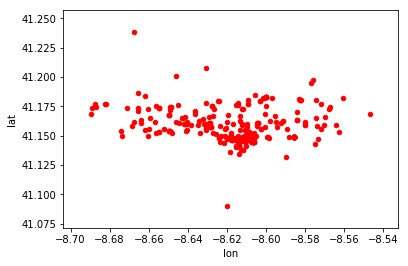

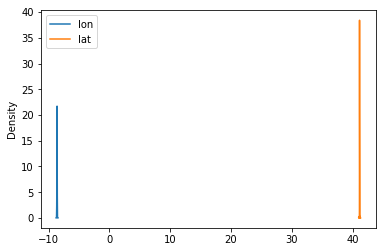

In [56]:
zf = zipfile.ZipFile('../input/test.csv.zip')
test = pd.read_csv(zf.open('test.csv'), usecols=['TRIP_ID', 'POLYLINE'])
test['POLYLINE'] = test['POLYLINE'].apply(json.loads)
test['snapshots'] = test['POLYLINE'].apply(lambda x: np.log(len(x)))
test['lonlat'] = test['POLYLINE'].apply(lambda x: x[0])
test.drop('POLYLINE', axis=1, inplace=True)
list1 = []
list2 = []
for ele in test['lonlat']:
    list1.append(ele[0])
    list2.append(ele[1])
df1 = pd.DataFrame(
    {'lon': list1,
     'lat': list2,
    })
ax1 = df1.plot.scatter(x='lon',y='lat',c='red')
ax = df1.plot.kde()

***

mean
661.78125
var
1002199.0115595611


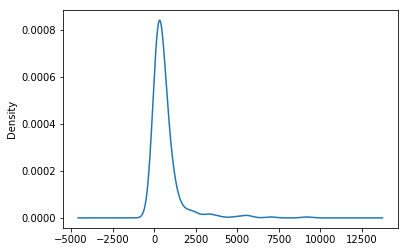

In [57]:
test = pd.read_csv(zf.open('test.csv'),nrows=50000)
test['TIME'] = test.POLYLINE.apply(lambda x:(len(eval(x)) - 1 ) * 15)
test = test[test.TIME>=0]
test.TIME.plot(kind="kde")
print ('mean')
print (test.TIME.mean())
print ('var') 
print (test.TIME.var())
plt.savefig("time.png")

#  <font color=red>READ TRAIN DATA</font>

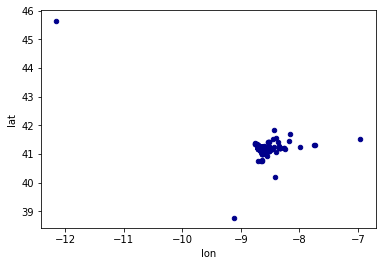

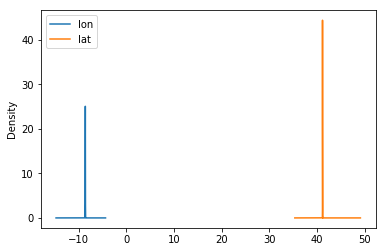

In [48]:
zf = zipfile.ZipFile('../input/train.csv.zip')
train = pd.read_csv(zf.open('train.csv'), usecols=['POLYLINE'], nrows=N_read)
train['POLYLINE'] = train['POLYLINE'].apply(json.loads)
train['snapshots'] = train['POLYLINE'].apply(lambda x: np.log(len(x)))
train = train[train.snapshots>3.0]
train['lonlat'] = train['POLYLINE'].apply(lambda x: x[0])
train.drop('POLYLINE', axis=1, inplace=True)

list3 = []
list4 = []
for ele in train['lonlat']:
    list3.append(ele[0])
    list4.append(ele[1])
df2 = pd.DataFrame(
    {'lon': list3,
     'lat': list4,
    })
ax1 = df2.plot.scatter(x='lon',y='lat',c='DarkBlue')
ax = df2.plot.kde()

***

#  <font color=red>Test Travel Time</font>

### Weighted mean of trip duration
### Bound below by 10 meters since we use 1/distance^2 as weight
### Treat 5% of longest lasting trips as outliers 

In [49]:
test['TRAVEL_TIME'] = 0
for row, ll in enumerate(test['lonlat']):
    d = train['lonlat'].apply(lambda x: get_dist(x, ll))
    i = np.argpartition(d, N_trips)[0:N_trips]
    w = np.maximum(d.iloc[i], 0.01)
    s = train.iloc[i]['snapshots']
    j = np.argpartition(s, int(N_trips*P_keep))[0:int(N_trips*P_keep)]
    test.loc[row, 'TRAVEL_TIME'] = np.maximum(P_pad*test.loc[row, 'snapshots'], np.average(s.iloc[j], weights=1/w.iloc[j]**2))


***

#  <font color=red>Blend with test average</font>

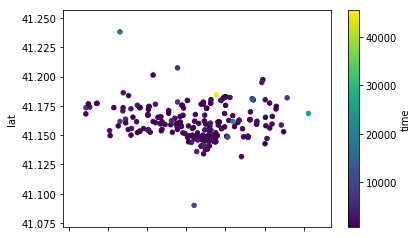

In [50]:
test['TRAVEL_TIME'] = 15*np.exp(.5*test['TRAVEL_TIME']+.5*P_pad*np.maximum(test.snapshots.mean(), test['snapshots']))
test['TRAVEL_TIME'] = test['TRAVEL_TIME'].astype(int)
test[['TRIP_ID', 'TRAVEL_TIME']].to_csv('submission.csv', index=False)

list5 = list(test['TRAVEL_TIME'])
df3 = pd.DataFrame(
    {'lon': list1,
     'lat': list2,
     'time':list5
    })
ax1 = df3.plot.scatter(x='lon',y='lat',c='time',colormap='viridis')